In [1]:
from heuristic.trainNetwork import TrainNetwork
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import traceback
from multiprocessing import Pool
from typing import List,Dict,Literal
from pydantic import BaseModel
from random import shuffle
from folium import folium , Marker, PolyLine, CircleMarker
from IPython.display import clear_output

# Heuristic End to End Search Helper Function Test

In [2]:
trainNetwork = TrainNetwork()
trainNetwork.load("./heuristic/trainNetwork.save.json")
v = trainNetwork.getRandomVerticesID(2)
samplePath = trainNetwork.breadthFirstSearch(v.get("res")[0],v.get("res")[1]).get("res").get("path")

sampleResult = [trainNetwork.vertices[stationID] for stationID in samplePath ]

sampleCentroid= [
    sum([float(res.get("coordinate").get("lat")) for res in sampleResult])/len(sampleResult),
    sum([float(res.get("coordinate").get("lon")) for res in sampleResult])/len(sampleResult)
]

sampleCoordinate = [ 
    [
        float(res.get("coordinate").get("lat")),
         float(res.get("coordinate").get("lon")) 
    ]
     for res in sampleResult
]

SampleMap = folium.Map(location = sampleCentroid, zoom_start = 12) 
PolyLine(sampleCoordinate,color="red", weight=3.5, opacity=1).add_to(SampleMap)
for i in range(len(sampleCoordinate)):
    CircleMarker(location=sampleCoordinate[i],radius=3,color='red',fill=True,fill_color='red').add_to(SampleMap)
    if(i==0 or i == len(sampleCoordinate)-1):   
        Marker(location= sampleCoordinate[i]).add_to(SampleMap)

SampleMap

loaded edges and vertices


# Q Learning Model

In [3]:
class Solution(BaseModel):
    solution: List[str]
    distance: int

# Q Learning 

In [4]:
class QLearning:
    def __init__(self,graph:TrainNetwork,data:List[str],startVertices:str,endVertices:str,policy:str=Literal["stochastics","epsilon-greedy"]):
        self.graph:TrainNetwork = graph
        self.data = [d for d in data if d != startVertices and d != endVertices].copy()
        self.startVertices = startVertices
        self.endVertices = endVertices
        self.qTable = {}
        self.distanceGraph = {}
        self.policy = policy
        
    def setupDistanceGraph(self):
        locations = [self.startVertices] + self.data + [self.endVertices] if self.startVertices != self.endVertices else [self.startVertices] + self.data 
        distanceGraph = {}
        for fromLoc in locations:
            if  distanceGraph.get(fromLoc) is None:  distanceGraph[fromLoc] = {} 
            for toLoc in locations:
                if fromLoc==toLoc:
                    distanceGraph[fromLoc][toLoc] = 0
                else:
                    travel = self.graph.breadthFirstSearch(fromLoc,toLoc)
                    if(travel.get("err")): raise travel.get("err")
                    distanceGraph[fromLoc][toLoc] =len(travel.get("res").get("path"))
        return distanceGraph
    
    def setupQTable(self):
        data = [*self.data,self.startVertices] if self.startVertices == self.endVertices else [self.endVertices, *self.data, self.startVertices]
        for i in range(len(data)):
            self.qTable[data[i]] = {}
            for j in range(len(data)):
                self.qTable[data[i]][data[j]] = 1
                
    def getSolutionDistance(self,solution):
        solution = solution if solution[0] == self.startVertices else [self.startVertices]+solution
        solution = solution if solution[len(solution)-1] == self.endVertices else solution+[self.endVertices]
        dist = self.distanceGraph[self.startVertices][solution[0]]
        for i in range(len(solution)):
            currentNode = solution[i]
            nextNode = solution[i+1] if(i != len(solution)-1) else self.endVertices
            dist += self.distanceGraph[currentNode][nextNode]
        return dist
                
    def randomSolution(self):
        generated_soln = []
        data = self.data.copy()
        
        while len(data) > 0 :
            randomIndex = int(np.floor((np.random.rand())*len(data)))
            print(data[randomIndex])
            draw = data[randomIndex]
            generated_soln.append(draw)
            data = [station for station in data if station != draw]
            
        return Solution(
            solution = generated_soln,
            distance = self.getSolutionDistance(generated_soln)
        )

    def StepWiseQValueUpdate(self,fromNode,toNode,learning_rate):
        nextStepChoices = list(self.distanceGraph[toNode].keys())[2+i:] 
        expectedNextNode = min(self.distanceGraph[toNode].keys())
        # reward = rewards*np.exp(-1*((1/self.bestSoln.distance)-(1/self.currentSoln.distance))/(1/self.bestSoln.distance)) if not expectedNextNode or self.distanceGraph[toNode][expectedNextNode] ==0  else 1/self.distanceGraph[toNode][expectedNextNode] 
        reward = rewards if not expectedNextNode or self.distanceGraph[toNode][expectedNextNode] ==0  else 1/self.distanceGraph[toNode][expectedNextNode] 
        # self.qTable[fromNode][toNode] *= (1-learning_rate)
        self.qTable[fromNode][toNode]  += learning_rate*(reward+discount_factor*max(self.qTable[toNode].values()))


    def stochasticQvalueSampling(self,previousNode,choices):
        probability = np.random.rand()
        denominator = sum([self.qTable[previousNode][choice] for choice in choices])
        norminator = 0
        for currentNode in choices:
            norminator += self.qTable[previousNode][currentNode]
            cummulativeProbability = norminator/denominator
            # print("cummulativeProbability = ", cummulativeProbability)
            if probability <= cummulativeProbability:
                return currentNode

    def randomSelection(self,previousNode,choices):
        currentNode=choices[int(np.random.rand()*len(choices))]
        return currentNode

    def maximumQvalueSelection(self,previousNode,choices):
        possible_currentNode = {}
        for choice in choices:
            possible_currentNode = {**possible_currentNode, choice:self.qTable[previousNode][choice]}
        currentNode = max(possible_currentNode,key=possible_currentNode.get)
        return currentNode

    def EpisodeWiseQValueUpdate(self,learning_rate,rewards,discount_factor):
         # update qTable
        '''
        Q(s,a)=Q(s,a) + α(r+γ maxQ(s',a')−Q(s,a))
        Q(s,a)= Q(s,a)*(1-α) + α(r+γ maxQ(s',a'))
        '''
        # Q(s,a)*(1-α) vaporize the influence of all Q value 
        for fromNode in self.qTable.keys():
            for toNode in self.qTable[fromNode].keys():
                self.qTable[fromNode][toNode] *= (1-learning_rate)
                
        # α(r+γ maxQ(s',a')) strengthen the influence of best solution Q value 
        bestSoln = self.bestSoln.solution if self.bestSoln.solution[0] == self.startVertices else [self.startVertices]+self.bestSoln.solution
        for i in range(len(bestSoln)):
            if i>0:
                fromNode,toNode = bestSoln[i-1],bestSoln[i]
                self.qTable[fromNode][toNode] += learning_rate*(rewards+discount_factor*max(self.qTable[toNode].values()))

             
        
    def Train(self,epsilon:float,learning_rate:float,discount_factor:float,rewards:int,max_iter:int,decay_rate:float = 0.001):
        try:
            self.distanceGraph = self.setupDistanceGraph()
            self.setupQTable()
            self.bestSoln = self.randomSolution()
            self.currentSoln = self.bestSoln.copy()

            episodes = []
            bestSolnRecord = []
            currentSolnRecord = []   
            
            for itr in range(max_iter):
                visited = [];
                choices = self.data.copy()
                previousNode = self.startVertices
                
                # generate new solution
                while len(choices)>0:
                    match self.policy:
                        case "stochastics":
                            currentNode = self.stochasticQvalueSampling(previousNode,choices)
                            self.StepWiseQValueUpdate(previousNode,currentNode,learning_rate)
                            visited.append(currentNode)
                            choices = [c for c in choices if c!=currentNode]
                            previousNode = currentNode
                        case "epsilon-greedy":
                            chance = np.random.rand()
                            if chance >= epsilon*np.exp(-1*decay_rate*itr):
                                # visited = self.bestSoln.solution
                                
                                currentNode = self.maximumQvalueSelection(previousNode,choices)
                                self.StepWiseQValueUpdate(previousNode,currentNode,learning_rate)
                                visited.append(currentNode)
                                choices = [c for c in choices if c!=currentNode]
                                previousNode = currentNode
                            else:
                                currentNode = self.randomSelection(previousNode,choices)
                                self.StepWiseQValueUpdate(previousNode,currentNode,learning_rate)
                                visited.append(currentNode)
                                choices = [c for c in choices if c!=currentNode]
                                previousNode = currentNode
                    
                        
                self.currentSoln = Solution(
                    solution = [station for station in visited if station not in [self.startVertices,self.endVertices]],
                    distance = self.getSolutionDistance(visited)
                )
                self.bestSoln = self.bestSoln if self.bestSoln.distance < self.currentSoln.distance else self.currentSoln
                self.EpisodeWiseQValueUpdate(learning_rate,rewards,discount_factor)

                # Display
                episodes.append(itr+1)
                bestSolnRecord.append(self.bestSoln.distance)
                currentSolnRecord.append(self.currentSoln.distance) 

                clear_output(wait=True)
                plt.xlabel('episodes')
                plt.ylabel('number of station used')
                plt.plot(episodes, bestSolnRecord, label="Best Known Solution")
                plt.plot(episodes, currentSolnRecord,  label="Current Episode Solution")
                plt.legend()
                plt.show()
                    
                
                
            self.bestSoln.solution = [self.startVertices]+self.bestSoln.solution+[self.endVertices]
            return self.bestSoln
                    
                    
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            print(error) 

# Generate Test Data

In [5]:
stationIDs = trainNetwork.getRandomVerticesID(20).get("res")
stationIDs = ['KJ9', 'KJ18', 'KJ34', 'SP4', 'KJ4', 'PY40', 'KJ12', 'PY25', 'AG18', 'PY10']
# stationIDs = ['AG16','KJ35','AG11','PY21','AG1','PY27','PY22','KG33','KJ5','KJ9','SP8','KJ19','AG6','KG17','AG7','KG34','PY37','SP4','SP14','KJ6']
pd.DataFrame([trainNetwork.vertices[stationID] for stationID in stationIDs])

,id,stationName,coordinate
0,KJ9,Ampang Park,"{'lat': '3.159854', 'lon': '101.7191364'}"
1,KJ18,Kerinchi,"{'lat': '3.11556', 'lon': '101.66857'}"
2,KJ34,USJ 21,"{'lat': '3.0298519', 'lon': '101.5821081'}"
3,SP4,PWTC,"{'lat': '3.1665923', 'lon': '101.6936275'}"
4,KJ4,Sri Rampai,"{'lat': '3.19925', 'lon': '101.73727'}"
5,PY40,Cyberjaya City Centre,"{'lat': '2.9384406', 'lon': '101.6658618'}"
6,KJ12,Dang Wangi,"{'lat': '3.15685', 'lon': '101.70198'}"
7,PY25,Bandar Malaysia Utara,"{'lat': '3.11520', 'lon': '101.70236'}"
8,AG18,Ampang,"{'lat': '3.15032', 'lon': '101.76005'}"
9,PY10,Kepong Baru,"{'lat': '3.2115497', 'lon': '101.6484978'}"


In [6]:
stationIDs

['KJ9', 'KJ18', 'KJ34', 'SP4', 'KJ4', 'PY40', 'KJ12', 'PY25', 'AG18', 'PY10']

# Model Fitting

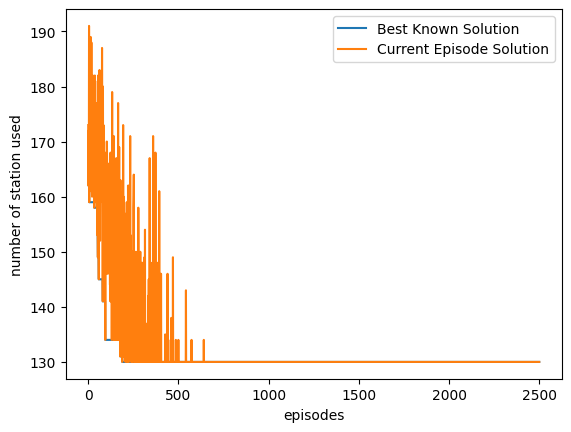

Solution(solution=['KJ9', 'AG18', 'PY25', 'PY40', 'KJ34', 'KJ18', 'KJ12', 'SP4', 'PY10', 'KJ4', 'KJ9'], distance=130)

In [7]:
start = stationIDs[0]
end = stationIDs[0]


epsilon=0.99
rewards=10
learning_rate=0.01
discount_factor=1-learning_rate
max_iter=2500
decay_rate:float = 1/(1.5*max_iter)
policy = "stochastics" # "epsilon-greedy"

qlearning = QLearning(trainNetwork,stationIDs,start,end,policy)

result = qlearning.Train(epsilon, learning_rate, discount_factor, rewards, max_iter,decay_rate)
result

In [8]:
pd.DataFrame([trainNetwork.vertices.get(stationID) for stationID in result.solution])

,id,stationName,coordinate
0,KJ9,Ampang Park,"{'lat': '3.159854', 'lon': '101.7191364'}"
1,AG18,Ampang,"{'lat': '3.15032', 'lon': '101.76005'}"
2,PY25,Bandar Malaysia Utara,"{'lat': '3.11520', 'lon': '101.70236'}"
3,PY40,Cyberjaya City Centre,"{'lat': '2.9384406', 'lon': '101.6658618'}"
4,KJ34,USJ 21,"{'lat': '3.0298519', 'lon': '101.5821081'}"
5,KJ18,Kerinchi,"{'lat': '3.11556', 'lon': '101.66857'}"
6,KJ12,Dang Wangi,"{'lat': '3.15685', 'lon': '101.70198'}"
7,SP4,PWTC,"{'lat': '3.1665923', 'lon': '101.6936275'}"
8,PY10,Kepong Baru,"{'lat': '3.2115497', 'lon': '101.6484978'}"
9,KJ4,Sri Rampai,"{'lat': '3.19925', 'lon': '101.73727'}"


In [9]:
stations = result.solution

paths = []
for i in range(len(stations)):
    if i < (len(stations)-1):
        # print(i,len(stations))
        from_id = stations[i]
        to_id = stations[i+1]
        travelRes = trainNetwork.breadthFirstSearch(fromID=from_id,toID=to_id)
        if(travelRes.get("err")) : print(travelRes)
        paths.append(travelRes.get("res").get("path"))

# print({"from":stations[0],"to":stations[len(stations)-1]})
allPath = []
for path in paths:
    if len(allPath)>0: path.pop(0)
    allPath = [*allPath,*path]

# print(allPath)

In [10]:
pathData = [trainNetwork.vertices[stationID] for stationID in allPath]
df = pd.DataFrame(pathData)
df

,id,stationName,coordinate
0,KJ9,Ampang Park,"{'lat': '3.159854', 'lon': '101.7191364'}"
1,KJ10,KLCC,"{'lat': '3.15908', 'lon': '101.71288'}"
2,KG18A,Bukit Bintang,"{'lat': '3.14659425', 'lon': '101.711222'}"
3,KG20,Tun Razak Exchange (TRX),"{'lat': '3.1427162', 'lon': '101.7202063'}"
4,KG21,Cochrane,"{'lat': '3.1327859', 'lon': '101.7229467'}"
...,...,...,...
116,KJ5,Setiawangsa,"{'lat': '3.1756', 'lon': '101.735735'}"
117,KJ6,Jelatek,"{'lat': '3.16734', 'lon': '101.73535'}"
118,KJ7,Dato' Keramat,"{'lat': '3.16515', 'lon': '101.7316'}"
119,KJ8,Damai,"{'lat': '3.1644056', 'lon': '101.7244889'}"


In [11]:
from folium import folium , Marker, PolyLine, CircleMarker

locations = [
    {
        "location":[
            float(path_data.get("coordinate").get("lat")),
            float(path_data.get("coordinate").get("lon"))
        ],
        "popup":path_data.get("stationName")
    }
    for path_data in pathData
]

lat = 0
lon = 0
points = []
for loc in locations:
    lat += loc.get("location")[0]
    lon += loc.get("location")[1]
    points.append(loc.get("location"))
centrold = [lat/len(locations),lon/len(locations)]

Map =  folium.Map(location=centrold, zoom_start = 12)
PolyLine(points,color="red", weight=3.5, opacity=1).add_to(Map)

for loc in locations:
     CircleMarker(
        location=loc.get("location"),
        popup=loc.get("popup"),
        radius=3,
        color='red',
        fill=True,
        fill_color='red'
   ).add_to(Map)
        
for i in range(len(stations)):
    node = trainNetwork.vertices.get(stations[i])
    Marker(
        location=[
            float(node.get("coordinate").get("lat")),
            float(node.get("coordinate").get("lon"))
        ], 
        popup=f'{str(i+1)} - {node.get("stationName")}',
    ).add_to(Map)
    
     
Map